# Libs and pre-definitions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#import sklearn
from sklearn import gaussian_process
from scipy import optimize,stats

In [2]:
def olivers_fn(X:np.array,x,w:float = 5,gamma:float = 0.3,noise = 0.1):
    y = np.prod(np.sin(w*(X))*(1-np.tanh(gamma*((X)**2))),-1,keepdims=True)
    if noise:
        y += np.random.normal(0,noise,y.shape)
    return y

In [3]:
def uniform_sample(shape,bounds,device = 'cpu'):
    return (bounds[0]-bounds[1])*np.rand(shape)+bounds[1]
def sigmoid(z):
    return 1/(1 + np.exp(-z))
class ThreeHump():
    def __init__(self,noise:float = 0) -> None:
        self.noise = noise
    def __call__(self,phi:np.array, x:np.array = None):
        y = 2*(phi[:, 0]**(2)) - 1.05*(phi[:, 0]**4) + phi[:, 0] ** 6 / 6 + phi[:,0] * phi[:,1] + phi[:, 1] ** 2
        if self.noise:
            y += x
        return y.reshape(-1,1)
    def sample_x(self,phi,*args):
        return np.random.randn((phi.shape[0],1))*self.noise

class stochastic_ThreeHump(ThreeHump):
    def __init__(self, n_samples = 1, average_x = False,bounds_1 = (-2,0), bounds_2 = (2,5)) -> None:
        super().__init__(0)
        self.bounds_1 = bounds_1
        self.bounds_2 = bounds_2
        self.n_samples = n_samples
        self.average_x = average_x
    @staticmethod
    def dif_sigma(x):
        return sigmoid(x-10)-sigmoid(x)
    def sample_x(self,phi,n_samples = 1):
        P1 = phi[:,0].div(phi.norm(p=2,dim=-1)).view(-1,1)
        mask = np.random.rand((phi.size(0),n_samples),device=phi.device).le(P1)
        x1 = uniform_sample((phi.size(0),n_samples),self.bounds_1)
        x2 = uniform_sample((phi.size(0),n_samples),self.bounds_2)
        return np.where(mask, x1, x2)
    def __call__(self, phi:np.array, x:np.array = None):
        if x is None: x = self.sample_x(phi)
        h = super().__call__(phi)
        if x is None: x = self.sample_x(phi,self.n_samples)*h
        mu = x + np.random.randn(*h.shape)
        y =  mu+np.random.randn(*h.shape)
        y = self.dif_sigma(y)
        if self.average_x: y = y.mean(-1)
        return y

# Gaussian Process

In [4]:
dimensions_phi = 2
#n_samples_x = 1
phi_sample = np.random.rand(100,dimensions_phi)
problem = olivers_fn#stochastic_ThreeHump()
x = 0#problem.sample_x(phi_sample,n_samples_x).view(-1,1)
y_sample = problem(phi_sample,x)
y_sample = (y_sample-y_sample.mean())/y_sample.std()
kernel = gaussian_process.kernels.RBF(length_scale=1.0, length_scale_bounds=(1e-05, 100000.0)) + gaussian_process.kernels.WhiteKernel(noise_level=0.1)
gpr = gaussian_process.GaussianProcessRegressor(kernel=kernel,random_state=42).fit(phi_sample, y_sample)

In [5]:
y_pred, std = gpr.predict(phi_sample,return_std = True)

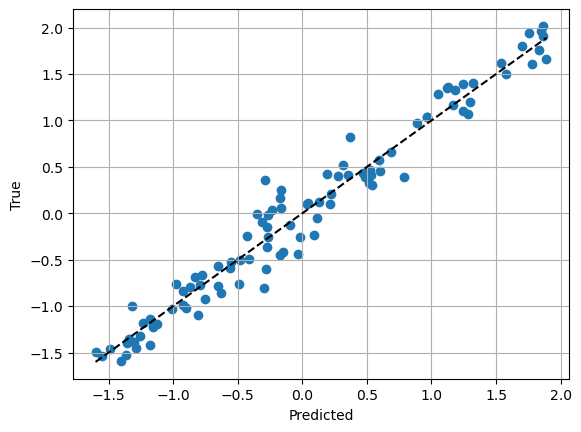

In [6]:
plt.scatter(y_pred,y_sample)
plt.grid()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.plot([y_pred.min(),y_pred.max()],[y_pred.min(),y_pred.max()],'k--')
plt.show()